# Gaussian Processes with GPyTorch
[GPyTorch](https://gpytorch.ai/) is a Gaussian process framework using PyTorch.
Compared to other frameworks (GPy, sklearn), GPyTorch allows for a higher level of control at the expense of a more complicated usage.

The following components are needed:
1. A model, e.g. `gpytorch.models.ExactGP` for non-variational GPs
2. A mean function for the GP model, e.g. `gpytorch.means.ConstantMean`
3. A covariance function for the GP model, e.g. `gpytorch.kernels.MaternKernel`
4. A likelihood, e.g. `gpytorch.likelihoods.GaussianLikelihood`, for modeling the noise
5. A distribution object, e.g. `gpytorch.distributions.MultivariateNormal`, holding the posterior mean and covariance at given inputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
import torch

### Example data

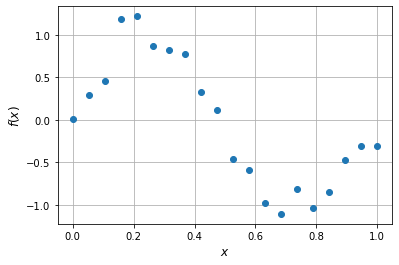

In [2]:
x_data = torch.linspace(0, 1, 20)
y_data = torch.sin(x_data * 2 * np.pi) + 0.2 * torch.randn(*x_data.shape)

fig, ax = plt.subplots(1)
ax.plot(x_data, y_data, "o")
ax.set(xlabel="$x$", ylabel="$f(x)$")
ax.grid();

### Model definition

As in PyTorch a user-built GP model implements the following two methods:
1. An `__init__` method that takes the training data and a likelihood, and constructs the necessary objects for the model's forward method.
2. A `forward` method that for given data $x$ returns a distribution object, e.g. `MultivariateNormal` with the prior mean and covariance evaluated at $x$.

Here we use a constant mean, a Matern 5/2 kernel and a Gaussian likelihood.

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(ExactGPModel, self).__init__(x, y, likelihood)
        self.mean = gpytorch.means.ConstantMean()
        self.kern = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(self.mean(x), self.kern(x))

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_data, y_data, likelihood)

In [4]:
model

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean): ConstantMean()
  (kern): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

### Parameters

The **raw** parameters are initialized to 0:

In [5]:
for name, param in model.named_parameters():
    print(f"{name:35} = {param.item()}")

likelihood.noise_covar.raw_noise    = 0.0
mean.constant                       = 0.0
kern.raw_outputscale                = 0.0
kern.base_kernel.raw_lengthscale    = 0.0


and have the following default constraints:

In [6]:
for name, constraint in model.named_constraints():
    print(f'{name:45} = {constraint}')

likelihood.noise_covar.raw_noise_constraint   = GreaterThan(1.000E-04)
kern.raw_outputscale_constraint               = Positive()
kern.base_kernel.raw_lengthscale_constraint   = Positive()


Constraints define a `transform` and `inverseTransform` method that transform from the raw to actual parameter values and vice versa. When we set the actual outputscale value to a non-zero value we see that raw and actual value differ (the actual value is the softplus $\log(1 + e^x)$ of the raw value).

In [7]:
k = model.kern
k.outputscale = 1  # set the actual value to 1
print(f"outputscale: raw={k.raw_outputscale:.3f}, actual={k.outputscale:.3f}")

outputscale: raw=0.541, actual=1.000


### Model training

As in PyTorch we need to implement the training loop ourself.

In [8]:
def print_parameters():
    loss = - mll(model(x_data), y_data).item()
    ls = model.kern.base_kernel.lengthscale.item()
    σ_kern = model.kern.outputscale.item() ** .5
    σ_noise = model.likelihood.noise.item() ** .5
    print(f"loss: {loss:.3f}, lengthscale: {ls:.3f}, scale: {σ_kern:.3f}, noise: {σ_noise:.3f}")

In [9]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    loss = - mll(model(x_data), y_data)
    loss.backward()
    optimizer.step()
    
print_parameters()

loss: 0.146, lengthscale: 0.250, scale: 0.717, noise: 0.147


We can also use LBFGS as a quasi-Newton optimizer.

In [10]:
model.train()
likelihood.train()

optimizer = torch.optim.LBFGS([{'params': model.parameters()}], lr=0.5)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    loss = - mll(model(x_data), y_data)
    loss.backward()
    return loss
    
for i in range(15):
    optimizer.step(closure)
    
print_parameters()

loss: 0.145, lengthscale: 0.253, scale: 0.725, noise: 0.148


### Make predictions

Making predictions (evaluating the posterior predictive) is rather straightforward.

In [11]:
# switch to evaluation mode
model.eval()
likelihood.eval()

# evaluate at new points
with torch.no_grad():
    x_new = torch.linspace(0, 1, 101)
    f_pred = model(x_new)  # noise-less predictions
    y_pred = likelihood(model(x_new))  # predictions including noise

/home/walzds/.local/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


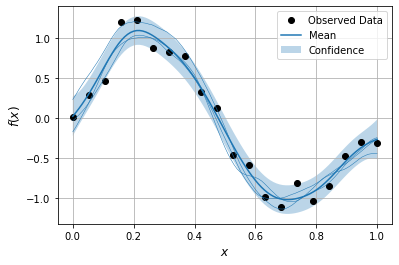

In [12]:
fig, ax = plt.subplots(1)
ax.plot(x_data, y_data, 'ko')
ax.plot(x_new, f_pred.mean)
lower, upper = f_pred.confidence_region()
ax.fill_between(x_new, lower, upper, alpha=0.3)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
f_samples = f_pred.sample(sample_shape=torch.Size([3]))
ax.plot(x_new, f_samples.T, 'C0', lw=0.5)
ax.set(xlabel="$x$", ylabel="$f(x)$")
ax.grid();

In [13]:
%load_ext watermark
%watermark -v -m -p gpytorch,torch

CPython 3.8.0
IPython 7.9.0

gpytorch 0.3.6
torch 1.3.1

compiler   : GCC 9.2.0
system     : Linux
release    : 4.4.0-43-Microsoft
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit
